In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib

In [5]:
df = pd.read_parquet('/content/drive/MyDrive/GDM5 project/data/combined_data.parquet')

In [4]:
df

NameError: name 'df' is not defined

In [6]:
# how many values  in colunm asset_id ?
df['status_type_id'].value_counts()

,count
status_type_id,
0,898672
5,260387
3,23689
4,13999


In [7]:
#je veux créer une variable STATUS_ID qui vaut "normal" si la valeur de status_type_id vaut 0 ou 2 et "not normal" sinon
df['status_id'] = np.where(df['status_type_id'].isin([0, 2]), 'normal', 'not normal')

In [8]:
df['status_id'].value_counts()

,count
status_id,
normal,898672
not normal,298075


In [9]:
sensor_columns = [col for col in df.columns if any(x in col for x in
                        ['sensor', 'wind_speed', 'power'])]
len(sensor_columns)

81

In [10]:

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        """
        Architecture de l'autoencoder pour la détection d'anomalies

        Args:
            input_dim: Dimension des données d'entrée (nombre de capteurs)
            encoding_dim: Dimension de la couche latente (compressée)
        """
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 44),
            nn.LeakyReLU(),
            nn.Linear(44, 25),
            nn.LeakyReLU(),
            nn.Linear(25, 4),  # Couche latente
            nn.LeakyReLU()
        )

        # Décodeur - reconstruit les données à partir de la représentation compressée
        self.decoder = nn.Sequential(
            nn.Linear(4, 25),
            nn.LeakyReLU(),
            nn.Linear(25, 44),
            nn.LeakyReLU(),
            nn.Linear(44, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Propagation avant: encode puis décode les données"""
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [12]:
class REPredictor(nn.Module):
    """Neural Network for predicting Reconstruction Error."""
    def __init__(self, input_dim, hidden_dim=30):
        super(REPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)  # Outputting a single RE value
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
class WindTurbineAnomalyDetector:
    def __init__(self, encoding_dim=16, hidden_dim=30,gamma=0.344):
        """
        Détecteur d'anomalies pour les données d'éoliennes

        Args:
            encoding_dim: Dimension de la couche latente de l'autoencoder
        """
        self.encoding_dim = encoding_dim
        self.scaler = StandardScaler()  # Pour normaliser les données
        self.model = None
        self.hidden_dim = hidden_dim # Assigned hidden_dim to an attribute
        self.re_predictor = None
        self.gamma = gamma
        self.threshold = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Utilisation de: {self.device}")

    def preprocess_data(self, df):
        """
        Prétraitement des données: sélection et normalisation des capteurs

        Args:
            df: DataFrame contenant les données des capteurs

        Returns:
            X_scaled: Données normalisées
            sensor_columns: Noms des colonnes sélectionnées
        """
        # Sélection des colonnes pertinentes (capteurs uniquement)
        sensor_columns = [col for col in df.columns if any(x in col for x in
                        ['sensor', 'wind_speed', 'power'])]

        print(f"Nombre de capteurs sélectionnés: {len(sensor_columns)}")

        # Vérification et nettoyage des données
        X = df[sensor_columns].copy()

        # Remplacer les valeurs infinies par NaN
        X.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Vérifier s'il y a des valeurs NaN et les remplacer par la moyenne de la colonne
        if X.isna().any().any():
            print(f"Attention: {X.isna().sum().sum()} valeurs NaN détectées et remplacées")
            X.fillna(X.mean(), inplace=True)

        # Normalisation des caractéristiques
        X_scaled = self.scaler.fit_transform(X)

        return X_scaled, sensor_columns
    def train_re_predictor(self, normal_data, epochs=300, batch_size=64, learning_rate=0.001, patience=10, checkpoint_dir='checkpoints_NN'):
        """Trains the RE Predictor NN with early stopping."""

        X, _ = self.preprocess_data(normal_data)  # Preprocess normal data
        if self.re_predictor is None:
            self.re_predictor = REPredictor(input_dim=X.shape[1], hidden_dim=self.hidden_dim).to(self.device)

        X_tensor = torch.FloatTensor(X).to(self.device)
        dataset = TensorDataset(X_tensor, X_tensor)  # Input = Output (for RE)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()  # Loss function for regression
        optimizer = optim.Adam(self.re_predictor.parameters(), lr=learning_rate)

        best_loss = float('inf')
        epochs_without_improvement = 0
        # Create checkpoint directory if it doesn't exist
        Path(checkpoint_dir).mkdir(exist_ok=True)
        start_epoch = 0
        # Load the latest checkpoint if it exists
        checkpoints = list(Path(checkpoint_dir).glob('epoch_NN_*.pth'))
        if checkpoints:
            latest_checkpoint = max(checkpoints, key=lambda p: int(p.stem.split('_')[2]))
            checkpoint = torch.load(latest_checkpoint)
            start_epoch = checkpoint['epoch']
            self.re_predictor.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"RE Predictor: Reprise de l'entraînement à partir de l'epoch {start_epoch}")
        for epoch in range(epochs):
            epoch_loss = 0
            self.re_predictor.train()  # Set the model to training mode

            for data, _ in dataloader:
                # Forward pass
                outputs = self.re_predictor(data)
                loss = criterion(outputs, data)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(dataloader)
            print(f'RE Predictor Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}')

            # Early stopping check
            if avg_loss < best_loss:
                best_loss = avg_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs.')
                    break
                    # Save checkpoint after each epoch
            checkpoint_path = Path(checkpoint_dir) / f'epoch_NN_{epoch + 1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': self.re_predictor.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)

    def train(self, df, epochs=50, batch_size=64, learning_rate=0.0001,checkpoint_dir='checkpoints'):
        """
        Entraînement de l'autoencoder

        Args:
            df: DataFrame contenant les données d'entraînement
            epochs: Nombre d'époques d'entraînement
            batch_size: Taille des lots pour l'entraînement
            learning_rate: Taux d'apprentissage

        Returns:
            losses: Liste des pertes d'entraînement
        """
        # Prétraitement des données
        X, sensor_columns = self.preprocess_data(df)

        # Conversion en tenseurs PyTorch
        X_tensor = torch.FloatTensor(X).to(self.device)
        dataset = TensorDataset(X_tensor, X_tensor)  # Les entrées = sorties attendues
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Construction du modèle
        if self.model is None:
            self.model = Autoencoder(X.shape[1], self.encoding_dim).to(self.device)
            print(f"Modèle créé avec {X.shape[1]} entrées et dimension latente de {self.encoding_dim}")

        # Fonction de perte et optimiseur
        criterion = nn.MSELoss()  # Erreur quadratique moyenne
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Ajout de régularisation L2

        # Créer le répertoire de checkpoints s'il n'existe pas
        Path(checkpoint_dir).mkdir(exist_ok=True)

        start_epoch = 0
        # Charger le dernier checkpoint s'il existe
        checkpoints = list(Path(checkpoint_dir).glob('epoch_*.pth'))
        if checkpoints:
            latest_checkpoint = max(checkpoints, key=lambda p: int(p.stem.split('_')[1]))
            checkpoint = torch.load(latest_checkpoint)
            start_epoch = checkpoint['epoch']
            self.model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Reprise de l'entraînement à partir de l'epoch {start_epoch}")

        # Boucle d'entraînement
        losses = []
        self.model.train()  # Mode entraînement
        # Boucle d'entraînement
        losses = []
        self.model.train()  # Mode entraînement

        print("Début de l'entraînement...")
        for epoch in range(start_epoch,epochs):

            epoch_loss = 0
            for data, _ in dataloader:
                # Propagation avant
                outputs = self.model(data)
                loss = criterion(outputs, data)

                # Vérification de la perte
                if torch.isnan(loss):
                    print(f"Alerte: Perte NaN détectée à l'époque {epoch+1}. Arrêt de l'entraînement.")
                    return losses

                # Rétropropagation
                optimizer.zero_grad()  # Réinitialisation des gradients
                loss.backward()        # Calcul des gradients

                # Clip des gradients pour éviter l'explosion
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()       # Mise à jour des poids

                epoch_loss += loss.item()

            # Calcul de la perte moyenne pour cette époque
            avg_loss = epoch_loss / len(dataloader)
            losses.append(avg_loss)

            print(f'Époque [{epoch+1}/{epochs}], Perte: {avg_loss:.6f}')
            # Enregistrer le checkpoint
            checkpoint_path = Path(checkpoint_dir) / f'epoch_{epoch + 1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, checkpoint_path)

        print("Entraînement terminé!")

        # Calcul du seuil d'erreur de reconstruction
        self.model.eval()  # Mode évaluation
        with torch.no_grad():
            reconstructions = self.model(X_tensor).cpu().numpy()

        # Calcul de l'erreur quadratique moyenne pour chaque exemple
        mse = np.mean(np.power(X - reconstructions, 2), axis=1)

        # Définition du seuil comme le 95ème percentile des erreurs
        self.threshold = np.percentile(mse, 95)
        print(f"Seuil d'anomalie calculé: {self.threshold:.6f}")

        return losses

    def detect_anomalies(self, df):
        """
        Détection des anomalies dans les données

        Args:
            df: DataFrame contenant les données à analyser

        Returns:
            results: DataFrame avec les erreurs de reconstruction et les anomalies
        """
        # Prétraitement des données
        X, _ = self.preprocess_data(df)

        # Conversion en tenseurs PyTorch + noise
        noise_factor = 0.06
        X_tensor = torch.FloatTensor(X).to(self.device)
        X_tensor = X_tensor + noise_factor * torch.randn(X_tensor.shape).to(self.device)
        # Obtention des reconstructions
        self.model.eval()
        with torch.no_grad():
            reconstructions = self.model(X_tensor).cpu().numpy()

        # Calcul de l'erreur MSE
        expected_re = self.re_predictor(X_tensor).detach().cpu().numpy().flatten()
        threshold = expected_re + gamma
        mse = np.mean(np.power(X - reconstructions, 2), axis=1)

        # Détection des anomalies (erreur > seuil)
        anomalies = mse > threshold

        # Création d'un DataFrame avec les résultats
        results = pd.DataFrame({
            'reconstruction_error': mse,
            'anomaly': anomalies
        }, index=df.index)

        return results

    def plot_history(self, losses):
        """Visualisation de l'historique d'entraînement"""
        plt.figure(figsize=(12, 4))
        plt.plot(losses)
        plt.title('Évolution de la perte pendant l\'entraînement')
        plt.xlabel('Époque')
        plt.ylabel('Perte (MSE)')
        plt.grid(True)
        plt.show()

    def plot_anomalies(self, df, results):
        """Visualisation des anomalies détectées"""
        plt.figure(figsize=(15, 7))

        # Tri par timestamp
        df_sorted = df.sort_values('time_stamp')
        results_sorted = results.loc[df_sorted.index]

        # Tracé de l'erreur de reconstruction
        plt.scatter(df_sorted['time_stamp'], results_sorted['reconstruction_error'],
                   c=results_sorted['anomaly'], cmap='coolwarm', alpha=0.7)

        plt.axhline(y=self.threshold, color='r', linestyle='--', label=f'Seuil ({self.threshold:.4f})')
        plt.title('Détection d\'anomalies dans les données d\'éoliennes')
        plt.xlabel('Date')
        plt.ylabel('Erreur de reconstruction')
        plt.colorbar(label='Anomalie')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Distribution des erreurs de reconstruction
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(results['reconstruction_error'], bins=50, kde=True)
        plt.axvline(x=self.threshold, color='r', linestyle='--', label=f'Seuil ({self.threshold:.4f})')
        plt.title('Distribution des erreurs de reconstruction')
        plt.xlabel('Erreur de reconstruction')
        plt.ylabel('Fréquence')
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.boxplot(x=results['anomaly'], y=results['reconstruction_error'])
        plt.title('Erreurs de reconstruction par classe')
        plt.xlabel('Anomalie')
        plt.ylabel('Erreur de reconstruction')
        plt.tight_layout()
        plt.show()

In [14]:
def analyze_sensor_contribution(detector, test_data, anomaly_results):
    """Analyse la contribution de chaque capteur aux anomalies détectées"""
    # Prétraitement des données
    X, sensor_columns = detector.preprocess_data(test_data)

    # Conversion en tenseurs PyTorch
    X_tensor = torch.FloatTensor(X).to(detector.device)

    # Obtention des reconstructions
    detector.model.eval()
    with torch.no_grad():
        reconstructions = detector.model(X_tensor).cpu().numpy()

    # Calcul de l'erreur par capteur
    sensor_errors = np.power(X - reconstructions, 2)

    # Création d'un DataFrame avec les erreurs par capteur
    sensor_error_df = pd.DataFrame(sensor_errors, columns=sensor_columns)

    # Ajout de l'information d'anomalie
    sensor_error_df['anomaly'] = anomaly_results['anomaly'].values

    # Calcul de l'erreur moyenne par capteur pour les anomalies vs non-anomalies
    anomaly_errors = sensor_error_df[sensor_error_df['anomaly']].mean()
    normal_errors = sensor_error_df[~sensor_error_df['anomaly']].mean()

    # Calcul du ratio d'erreur (anomalie / normal)
    error_ratio = anomaly_errors / normal_errors
    error_ratio = error_ratio.drop('anomaly')

    # Tri des capteurs par ratio d'erreur
    top_sensors = error_ratio.sort_values(ascending=False)

    return top_sensors, sensor_error_df



Données d'entraînement: 859574 lignes
Données de test: 50593 lignes
Utilisation de: cuda
Nombre de capteurs sélectionnés: 81
Attention: 10 valeurs NaN détectées et remplacées
Modèle créé avec 81 entrées et dimension latente de 16


<ipython-input-13-94093113edc5>:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint)


Reprise de l'entraînement à partir de l'epoch 20
Début de l'entraînement...
Entraînement terminé!
Seuil d'anomalie calculé: 2.007583
Nombre de capteurs sélectionnés: 81
Attention: 10 valeurs NaN détectées et remplacées


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 81])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([54, 81])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RE Predictor Epoch [1/300], Loss: 0.772981
RE Predictor Epoch [2/300], Loss: 0.773033
RE Predictor Epoch [3/300], Loss: 0.773096
RE Predictor Epoch [4/300], Loss: 0.773246
RE Predictor Epoch [5/300], Loss: 0.774543
RE Predictor Epoch [6/300], Loss: 0.798416
RE Predictor Epoch [7/300], Loss: 0.802432
RE Predictor Epoch [8/300], Loss: 0.859258
RE Predictor Epoch [9/300], Loss: 0.778915
RE Predictor Epoch [10/300], Loss: 0.775473
RE Predictor Epoch [11/300], Loss: 0.829625
Early stopping triggered after 11 epochs.


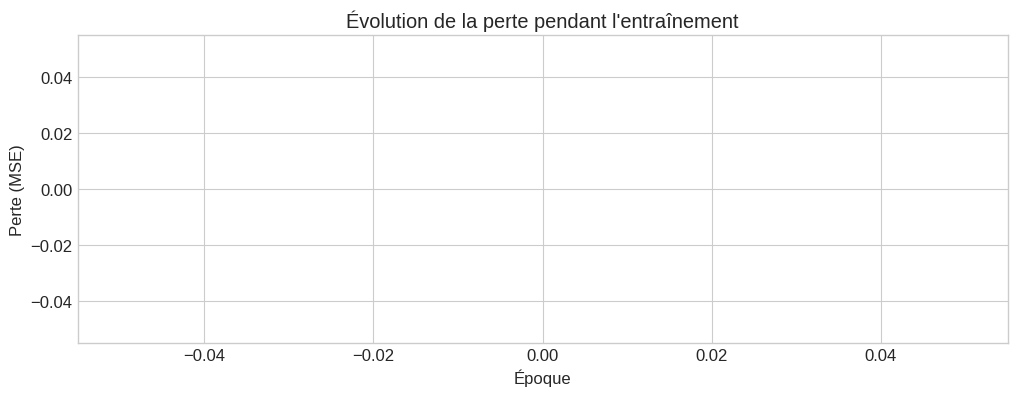

Détection des anomalies sur les données de test...
Nombre de capteurs sélectionnés: 81
Attention: 8 valeurs NaN détectées et remplacées


NameError: name 'gamma' is not defined

In [15]:
def run_analysis():
    # Chargement des données
    #data_path = Path(r'/content/drive/MyDrive/GDM5 project/combined_data.parquet')
    #df = pd.read_parquet(data_path)

    # Conversion du timestamp en format datetime
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='mixed')

    # Séparation des données d'entraînement et de test
    train_data = df[(df['train_test'] == 'train') & (df['status_id'] == 'normal')] # Nouvelle ligne
    test_data = df[df['train_test'] == 'prediction']

    print(f"\nDonnées d'entraînement: {len(train_data)} lignes")
    print(f"Données de test: {len(test_data)} lignes")

    # Création et entraînement du détecteur
    detector = WindTurbineAnomalyDetector(encoding_dim=16)
    losses = detector.train(train_data, epochs=20, batch_size=64, learning_rate=0.0018, checkpoint_dir='analysis_checkpoints')
    detector.train_re_predictor(normal_data=train_data, epochs=300, batch_size=64, learning_rate=0.001, checkpoint_dir='analysis_checkpoints')
    # Visualisation de l'entraînement
    detector.plot_history(losses)

    # Détection des anomalies
    print("Détection des anomalies sur les données de test...")
    anomaly_results = detector.detect_anomalies(test_data)

    # Statistiques des anomalies
    anomaly_count = anomaly_results['anomaly'].sum()
    print(f"Nombre d'anomalies détectées: {anomaly_count}")
    print(f"Pourcentage d'anomalies: {(anomaly_count / len(test_data)) * 100:.2f}%")

    # Visualisation des anomalies
    detector.plot_anomalies(test_data, anomaly_results)

    # Analyse des capteurs les plus influents
    top_sensors, sensor_error_df = analyze_sensor_contribution(detector, test_data, anomaly_results)

    # Visualisation des capteurs les plus influents
    plt.figure(figsize=(14, 6))
    top_sensors.head(15).plot(kind='bar')
    plt.title('Top 15 des capteurs contribuant le plus aux anomalies')
    plt.xlabel('Capteur')
    plt.ylabel('Ratio d\'erreur (Anomalie/Normal)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Sauvegarde du modèle
    model_path = Path(r'c:\Users\moham\Desktop\GDM5 project\models')
    model_path.mkdir(exist_ok=True)
    torch.save(detector.model.state_dict(), model_path / 'autoencoder_model.pth')
    joblib.dump(detector.scaler, model_path / 'scaler.pkl')
    joblib.dump(detector.threshold, model_path / 'threshold.pkl')

    return detector, anomaly_results, top_sensors

if __name__ == "__main__":
    # Exécuter l'analyse complète
    detector, anomaly_results, top_sensors = run_analysis()

In [ ]:
import os
import shutil

checkpoint_dir = 'analysis_checkpoints'  # Remplacez par le répertoire approprié

for filename in os.listdir(checkpoint_dir):
    if filename.startswith('epoch_') and filename.endswith('.pth'):
        file_path = os.path.join(checkpoint_dir, filename)
        os.remove(file_path)

# Ou, pour supprimer tout le contenu du répertoire :
# shutil.rmtree(checkpoint_dir)  # Attention, cela supprimera tout dans le répertoire !

In [ ]:
#how to know number of category in column

anomaly_results

In [28]:
class Coverage:
    def __init__(self, beta=0.5):
        """
        Initializes the Coverage class.

        Args:
            beta: Beta value for the Fβ-score (default: 0.5).
        """
        self.beta = beta

    def filter_prediction_time_frame(self, df):
        """
        Filters the prediction time frame to include only data points with a normal status ID.

        Args:
            df: DataFrame containing the data with a 'status_id' column.

        Returns:
            DataFrame containing only data points with a normal status ID.
        """
        filtered_df = df[df['status_id'] == 'normal']
        return filtered_df

    def calculate_fbeta_score(self, ground_truth, predictions):
        """
        Calculates the Fβ-score for the given ground truth and predictions.

        Args:
            ground_truth: Ground truth labels (0 or 1).
            predictions: Predicted labels (0 or 1).

        Returns:
            The Fβ-score.
        """
        tp = np.sum((ground_truth == 1) & (predictions == 1))
        fn = np.sum((ground_truth == 1) & (predictions == 0))
        fp = np.sum((ground_truth == 0) & (predictions == 1))

        fbeta = (1 + self.beta**2) * tp / ((1 + self.beta**2) * tp + self.beta**2 * fn + fp)
        return fbeta

    def calculate_coverage_score(self, df, anomaly_results):
        """
        Calculates the Coverage score for the given data and anomaly results.

        Args:
            df: Original DataFrame containing the data.
            anomaly_results: DataFrame containing the anomaly predictions.

        Returns:
            The Coverage score.
        """
        filtered_df = self.filter_prediction_time_frame(df)

        # Extract ground truth and predictions for the filtered time frame
        ground_truth = filtered_df['status_id'].map({'normal': 0, 'not normal': 1}).astype(int)
        predictions = anomaly_results['anomaly'].astype(int)

        # Calculate the Coverage score (Fβ-score)
        coverage_score = self.calculate_fbeta_score(ground_truth, predictions)
        return coverage_score

In [29]:
coverage_calculator = Coverage(beta=0.5)  # Create an instance of the class

# Calculate the Coverage score
coverage_score = coverage_calculator.calculate_coverage_score(df, anomaly_results)

print(f"Coverage Score: {coverage_score}")

Coverage Score: 0.0


In [ ]:
import pandas as pd
import numpy as np

class Accuracy:
    def __init__(self):
        """Initializes the Accuracy class."""
        pass  # No specific initialization needed for this score

    def filter_prediction_time_frame(self, df):
        """
        Filters the prediction time frame to include only data points with a normal status ID.

        Args:
            df: DataFrame containing the data with a 'status_id' column.

        Returns:
            DataFrame containing only data points with a normal status ID.
        """
        filtered_df = df[df['status_id'] == 'normal']
        return filtered_df

    def calculate_acc_score(self, ground_truth, predictions):
        """
        Calculates the Acc-score for the given ground truth and predictions.

        Args:
            ground_truth: Ground truth labels (0 or 1).
            predictions: Predicted labels (0 or 1).

        Returns:
            The Acc-score.
        """
        tn = np.sum((ground_truth == 0) & (predictions == 0))
        fp = np.sum((ground_truth == 0) & (predictions == 1))

        acc_score = tn / (fp + tn)
        return acc_score

    def calculate_accuracy_score(self, df, anomaly_results):
        """
        Calculates the Accuracy score for the given data and anomaly results.

        Args:
            df: Original DataFrame containing the data.
            anomaly_results: DataFrame containing the anomaly predictions.

        Returns:
            The Accuracy score.
        """
        filtered_df = self.filter_prediction_time_frame(df)

        # Extract ground truth and predictions for the filtered time frame
        ground_truth = filtered_df['anomaly'].astype(int)  # Convert anomaly column to 0/1
        predictions = anomaly_results.loc[filtered_df.index, 'anomaly'].astype(int)

        # Calculate the Accuracy score (Acc-score)
        accuracy_score = self.calculate_acc_score(ground_truth, predictions)
        return accuracy_score

In [ ]:
accuracy_calculator = Accuracy()  # Create an instance of the class

# Calculate the Accuracy score
accuracy_score = accuracy_calculator.calculate_accuracy_score(df, anomaly_results)

print(f"Accuracy Score: {accuracy_score}")

In [ ]:
import pandas as pd
import numpy as np

class ReliabilityScoreCalculator:
    def __init__(self, beta=0.5, threshold=72):
        """
        Initializes the ReliabilityScoreCalculator class.

        Args:
            beta: Beta value for Fβ-score (default: 0.5).
            threshold: Criticality threshold for event classification (default: 72).
        """
        self.beta = beta
        self.threshold = threshold

    def _calculate_criticality(self, status_info, predictions):
        """Calculates the criticality measure based on Algorithm 1."""
        crit = [0]
        for i in range(1, len(status_info)):
            if status_info[i] == 0:  # Abnormal status
                if predictions[i] == 1:  # Anomaly detected
                    crit.append(crit[-1] + 1)
                else:
                    crit.append(max(crit[-1] - 1, 0))
            else:  # Normal status
                crit.append(crit[-1])
        return crit

    def _classify_events(self, criticality):
        """Classifies predictions into anomaly events or normal behavior."""
        max_criticality = max(criticality)
        event_classifications = [1 if max_criticality > self.threshold else 0] * len(criticality)
        return event_classifications

    def _calculate_fbeta_score(self, ground_truth, predictions):
        """Calculates the Fβ-score."""
        tp = np.sum((ground_truth == 1) & (predictions == 1))
        fn = np.sum((ground_truth == 1) & (predictions == 0))
        fp = np.sum((ground_truth == 0) & (predictions == 1))
        fbeta = (1 + self.beta**2) * tp / ((1 + self.beta**2) * tp + self.beta**2 * fn + fp)
        return fbeta

    def calculate_reliability_score(self, df, anomaly_results):
        """
        Calculates the Reliability score using the event-based Fβ-score.

        Args:
            df: Original DataFrame with 'status_id' and 'anomaly' columns.
            anomaly_results: DataFrame with anomaly predictions.

        Returns:
            The Reliability score.
        """
        status_info = df['status_id'].map({'normal': 1, 'not normal': 0}).values
        predictions = anomaly_results['anomaly'].astype(int).values
        criticality = self._calculate_criticality(status_info, predictions)
        event_classifications = self._classify_events(criticality)
        ground_truth_events = df['anomaly'].astype(int).values
        return self._calculate_fbeta_score(ground_truth_events, event_classifications)

In [ ]:
# Assuming 'df' is your original DataFrame and 'anomaly_results' contains your predictions
reliability_calculator = ReliabilityScoreCalculator(beta=0.5, threshold=72)

# Calculate the Reliability score
reliability_score = reliability_calculator.calculate_reliability_score(df, anomaly_results)

print(f"Reliability Score: {reliability_score}")

In [ ]:
import pandas as pd
import numpy as np

class EarlinessScoreCalculator:
    def __init__(self):
        """Initializes the EarlinessScoreCalculator class."""
        pass  # No specific initialization needed for this score

    def _calculate_weighted_score(self, anomaly_event_timestamps, predictions):
        """Calculates the Weighted Score (WS) for an anomaly event."""
        num_timestamps = len(anomaly_event_timestamps)
        weights = np.ones(num_timestamps)  # Initialize weights to 1

        # Apply weighting function (linear decrease in second half)
        midpoint = num_timestamps // 2
        weights[midpoint:] = np.linspace(1, 0, num_timestamps - midpoint)

        # Calculate weighted score
        weighted_score = np.sum(weights * predictions) / np.sum(weights)
        return weighted_score

    def calculate_earliness_score(self, df, anomaly_results):
        """
        Calculates the Earliness score for the given data and anomaly results.

        Args:
            df: Original DataFrame with 'anomaly' column.
            anomaly_results: DataFrame with anomaly predictions.

        Returns:
            The Earliness score.
        """
        # Filter for anomaly events
        anomaly_events = df[df['anomaly'] == 1]

        # Get timestamps and predictions for each anomaly event
        event_timestamps = anomaly_events.index.tolist()
        event_predictions = anomaly_results.loc[event_timestamps, 'anomaly'].astype(int).values

        # Calculate weighted score for each event
        weighted_scores = []
        for i in range(len(event_timestamps)):
            weighted_scores.append(self._calculate_weighted_score([event_timestamps[i]], [event_predictions[i]]))

        # Calculate overall Earliness score (average of weighted scores)
        earliness_score = np.mean(weighted_scores) if weighted_scores else 0  # Handle case with no anomaly events
        return earliness_score

In [ ]:
# Assuming 'df' is your original DataFrame and 'anomaly_results' contains your predictions
earliness_calculator = EarlinessScoreCalculator()

# Calculate the Earliness score
earliness_score = earliness_calculator.calculate_earliness_score(df, anomaly_results)

print(f"Earliness Score: {earliness_score}")